In [1]:
cd ..

/Users/simonwolf/git/economics


In [2]:
# Data manipulation
import numpy as np
import utils
import prediction

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Prediction
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression

# sns.set_theme(style="whitegrid")

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.rcParams['figure.dpi'] = 150

In [3]:
df = utils.read_csv()

df[["Stock", "Sector", "Class", "Year"]] = df[["Stock", "Sector", "Class", "Year"]].astype("category")

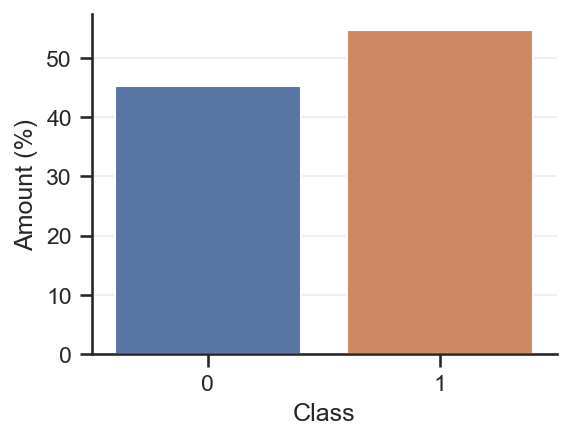

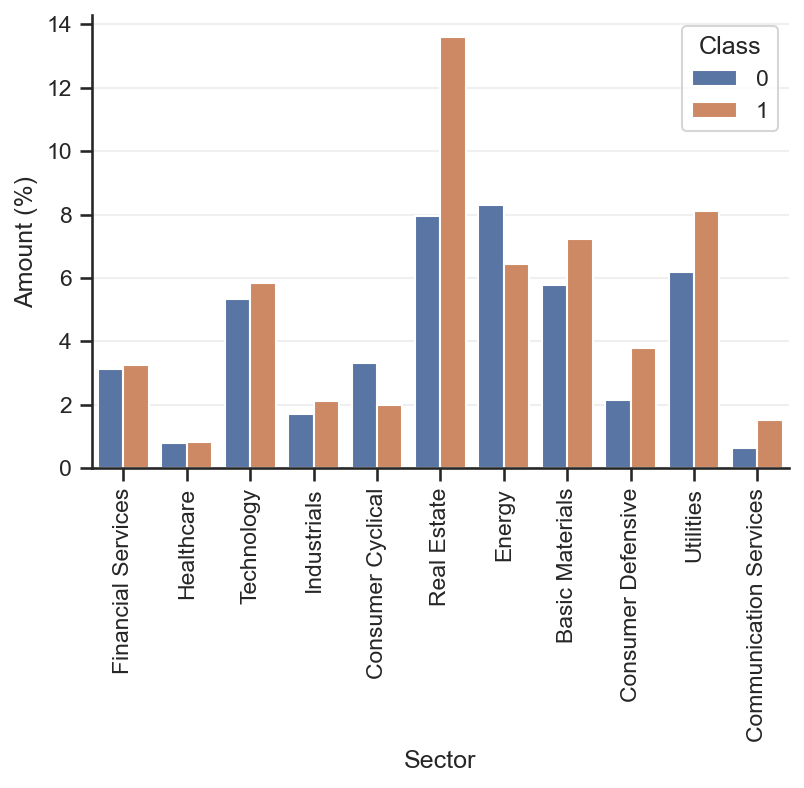

In [4]:
# Plot class distribution
df_class = df['Class'].value_counts() / df.shape[0] * 100
fig = plt.figure(figsize=(4,3))
sns.barplot([1,0], df_class)
plt.ylabel('Amount (%)')
plt.xlabel('Class')
plt.grid(alpha=0.3, axis='y')
#plt.title('CLASS COUNT', fontsize=10)
#plt.savefig("class_count_pred.png", bbox_inches="tight")
plt.show()

# Plot sector distribution
df_sector = df[['Sector', 'Class']].value_counts() / df.shape[0] * 100
df_sector.to_frame()
df_sector = df_sector.reset_index()
fig = plt.figure(figsize=(6,4))
sns.barplot(x='Sector', y=df_sector.iloc[:,2], hue='Class', data=df_sector)
plt.ylabel('Amount (%)')
plt.xlabel('Sector')
plt.xticks(np.arange(len(df_sector["Sector"].unique())), df_sector["Sector"].unique(), rotation=90)
plt.grid(alpha=0.3, axis='y')
#plt.title('SECTORS COUNT', fontsize=10)
#fig.savefig("sector_count_pred.png", bbox_inches="tight")
plt.show()

In [5]:
#Train - Test Split

# df_train, df_test = prediction.split_data_sets_for_svm(df, test_size=0.2)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Class"]), df["Class"], test_size=0.25,
                                                    random_state=42, shuffle=True, stratify=df["Class"])

---

## Model building

In [6]:
# Target Extraction
# df_train_target = df_train.pop("Class")
# df_test_target = df_test.pop("Class")

In [7]:
#Categorical and Continuous Variables
cont_vars = X_train.select_dtypes(include="number").columns.values
cat_vars = X_train.select_dtypes(include="category").columns.values

print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Revenue' 'Revenue Growth' 'Gross Profit' 'R&D Expenses' 'SG&A Expense'
 'Operating Expenses' 'Operating Income' 'Interest Expense'
 'Earnings before Tax' 'Income Tax Expense'
 'Net Income - Non-Controlling int' 'Net Income - Discontinued ops'
 'Net Income' 'Preferred Dividends' 'EPS' 'Weighted Average Shs Out'
 'Weighted Average Shs Out (Dil)' 'Dividend per Share' 'Gross Margin'
 'EBIT Margin' 'Free Cash Flow margin' 'EBITDA'
 'Cash and cash equivalents' 'Receivables' 'Inventories'
 'Property, Plant & Equipment Net' 'Goodwill and Intangible Assets'
 'Tax assets' 'Total assets' 'Payables' 'Long-term debt' 'Total debt'
 'Deferred revenue' 'Tax Liabilities' 'Deposit Liabilities'
 'Total liabilities' 'Other comprehensive income'
 'Retained earnings (deficit)' 'Total shareholders equity' 'Investments'
 'Other Liabilities' 'Depreciation & Amortization'
 'Stock-based compensation' 'Operating Cash Flow' 'Capital Expenditure'
 'Acquisitions and disposals' 'Investment pur

---

## Logit model as baseline

In [8]:
logit = LogisticRegression(class_weight='balanced')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, logit)

pipeline

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.64      0.64      0.64      2129
     class 1       0.70      0.70      0.70      2573

    accuracy                           0.68      4702
   macro avg       0.67      0.67      0.67      4702
weighted avg       0.68      0.68      0.68      4702



In [9]:
logit = LogisticRegression(class_weight='balanced')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, logit)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Receivables Turnover', 'Gross Profit Growth', 'EBIT Growth',
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
          

In [10]:
# Define Model Parameters for Grid Search
model_params = {
                'svc model__C':loguniform(1e0, 1e3),
                'svc model__tol':loguniform(1e-4, 1e1),
                'svc model__penalty':['l1','l2']
                }

In [11]:
# Grid Search
prediction.find_best_parameters_for_model(pipeline,
                                          X_train,
                                          y_train,
                                          model_params,
                                          scoring='f1',
                                          n_iter=50,
                                          n_splits=5,
                                          n_repeats=2,
                                          verbose=10)

Running grid search for the model based on f1
Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START svc model__C=13.292918943162162, svc model__penalty=l1, svc model__tol=0.0008263688714158008
[CV 1/10; 1/50] END svc model__C=13.292918943162162, svc model__penalty=l1, svc model__tol=0.0008263688714158008;, score=nan total time=   0.1s
[CV 2/10; 1/50] START svc model__C=13.292918943162162, svc model__penalty=l1, svc model__tol=0.0008263688714158008
[CV 2/10; 1/50] END svc model__C=13.292918943162162, svc model__penalty=l1, svc model__tol=0.0008263688714158008;, score=nan total time=   0.1s
[CV 3/10; 1/50] START svc model__C=13.292918943162162, svc model__penalty=l1, svc model__tol=0.0008263688714158008
[CV 3/10; 1/50] END svc model__C=13.292918943162162, svc model__penalty=l1, svc model__tol=0.0008263688714158008;, score=nan total time=   0.1s
[CV 4/10; 1/50] START svc model__C=13.292918943162162, svc model__penalty=l1, svc model__tol=0.0008263688714158008

[CV 2/10; 4/50] END svc model__C=10.025956902289565, svc model__penalty=l2, svc model__tol=0.3470266988650412;, score=0.668 total time=   0.4s
[CV 3/10; 4/50] START svc model__C=10.025956902289565, svc model__penalty=l2, svc model__tol=0.3470266988650412
[CV 3/10; 4/50] END svc model__C=10.025956902289565, svc model__penalty=l2, svc model__tol=0.3470266988650412;, score=0.683 total time=   0.5s
[CV 4/10; 4/50] START svc model__C=10.025956902289565, svc model__penalty=l2, svc model__tol=0.3470266988650412
[CV 4/10; 4/50] END svc model__C=10.025956902289565, svc model__penalty=l2, svc model__tol=0.3470266988650412;, score=0.672 total time=   0.5s
[CV 5/10; 4/50] START svc model__C=10.025956902289565, svc model__penalty=l2, svc model__tol=0.3470266988650412
[CV 5/10; 4/50] END svc model__C=10.025956902289565, svc model__penalty=l2, svc model__tol=0.3470266988650412;, score=0.679 total time=   0.5s
[CV 6/10; 4/50] START svc model__C=10.025956902289565, svc model__penalty=l2, svc model__tol

[CV 4/10; 7/50] END svc model__C=3.5498788321965016, svc model__penalty=l2, svc model__tol=0.11435780278433402;, score=0.685 total time=   0.5s
[CV 5/10; 7/50] START svc model__C=3.5498788321965016, svc model__penalty=l2, svc model__tol=0.11435780278433402
[CV 5/10; 7/50] END svc model__C=3.5498788321965016, svc model__penalty=l2, svc model__tol=0.11435780278433402;, score=0.689 total time=   0.4s
[CV 6/10; 7/50] START svc model__C=3.5498788321965016, svc model__penalty=l2, svc model__tol=0.11435780278433402
[CV 6/10; 7/50] END svc model__C=3.5498788321965016, svc model__penalty=l2, svc model__tol=0.11435780278433402;, score=0.690 total time=   0.4s
[CV 7/10; 7/50] START svc model__C=3.5498788321965016, svc model__penalty=l2, svc model__tol=0.11435780278433402
[CV 7/10; 7/50] END svc model__C=3.5498788321965016, svc model__penalty=l2, svc model__tol=0.11435780278433402;, score=0.675 total time=   0.4s
[CV 8/10; 7/50] START svc model__C=3.5498788321965016, svc model__penalty=l2, svc mod

[CV 8/10; 10/50] END svc model__C=834.1930294140774, svc model__penalty=l1, svc model__tol=0.01906996610300043;, score=nan total time=   0.1s
[CV 9/10; 10/50] START svc model__C=834.1930294140774, svc model__penalty=l1, svc model__tol=0.01906996610300043
[CV 9/10; 10/50] END svc model__C=834.1930294140774, svc model__penalty=l1, svc model__tol=0.01906996610300043;, score=nan total time=   0.1s
[CV 10/10; 10/50] START svc model__C=834.1930294140774, svc model__penalty=l1, svc model__tol=0.01906996610300043
[CV 10/10; 10/50] END svc model__C=834.1930294140774, svc model__penalty=l1, svc model__tol=0.01906996610300043;, score=nan total time=   0.1s
[CV 1/10; 11/50] START svc model__C=226.73986523780394, svc model__penalty=l1, svc model__tol=0.008171653749019032
[CV 1/10; 11/50] END svc model__C=226.73986523780394, svc model__penalty=l1, svc model__tol=0.008171653749019032;, score=nan total time=   0.1s
[CV 2/10; 11/50] START svc model__C=226.73986523780394, svc model__penalty=l1, svc mode

[CV 1/10; 14/50] END svc model__C=1.095960453692584, svc model__penalty=l1, svc model__tol=6.732248920775338;, score=nan total time=   0.1s
[CV 2/10; 14/50] START svc model__C=1.095960453692584, svc model__penalty=l1, svc model__tol=6.732248920775338
[CV 2/10; 14/50] END svc model__C=1.095960453692584, svc model__penalty=l1, svc model__tol=6.732248920775338;, score=nan total time=   0.1s
[CV 3/10; 14/50] START svc model__C=1.095960453692584, svc model__penalty=l1, svc model__tol=6.732248920775338
[CV 3/10; 14/50] END svc model__C=1.095960453692584, svc model__penalty=l1, svc model__tol=6.732248920775338;, score=nan total time=   0.1s
[CV 4/10; 14/50] START svc model__C=1.095960453692584, svc model__penalty=l1, svc model__tol=6.732248920775338
[CV 4/10; 14/50] END svc model__C=1.095960453692584, svc model__penalty=l1, svc model__tol=6.732248920775338;, score=nan total time=   0.1s
[CV 5/10; 14/50] START svc model__C=1.095960453692584, svc model__penalty=l1, svc model__tol=6.732248920775

[CV 5/10; 20/50] END svc model__C=4.205571187007207, svc model__penalty=l2, svc model__tol=0.0008399864445957498;, score=0.686 total time=   0.5s
[CV 6/10; 20/50] START svc model__C=4.205571187007207, svc model__penalty=l2, svc model__tol=0.0008399864445957498
[CV 6/10; 20/50] END svc model__C=4.205571187007207, svc model__penalty=l2, svc model__tol=0.0008399864445957498;, score=0.685 total time=   0.5s
[CV 7/10; 20/50] START svc model__C=4.205571187007207, svc model__penalty=l2, svc model__tol=0.0008399864445957498
[CV 7/10; 20/50] END svc model__C=4.205571187007207, svc model__penalty=l2, svc model__tol=0.0008399864445957498;, score=0.675 total time=   0.5s
[CV 8/10; 20/50] START svc model__C=4.205571187007207, svc model__penalty=l2, svc model__tol=0.0008399864445957498
[CV 8/10; 20/50] END svc model__C=4.205571187007207, svc model__penalty=l2, svc model__tol=0.0008399864445957498;, score=0.680 total time=   0.5s
[CV 9/10; 20/50] START svc model__C=4.205571187007207, svc model__penal

[CV 7/10; 23/50] END svc model__C=582.9384542994737, svc model__penalty=l2, svc model__tol=0.07115736737626974;, score=0.649 total time=   0.5s
[CV 8/10; 23/50] START svc model__C=582.9384542994737, svc model__penalty=l2, svc model__tol=0.07115736737626974
[CV 8/10; 23/50] END svc model__C=582.9384542994737, svc model__penalty=l2, svc model__tol=0.07115736737626974;, score=0.657 total time=   0.5s
[CV 9/10; 23/50] START svc model__C=582.9384542994737, svc model__penalty=l2, svc model__tol=0.07115736737626974
[CV 9/10; 23/50] END svc model__C=582.9384542994737, svc model__penalty=l2, svc model__tol=0.07115736737626974;, score=0.682 total time=   0.5s
[CV 10/10; 23/50] START svc model__C=582.9384542994737, svc model__penalty=l2, svc model__tol=0.07115736737626974
[CV 10/10; 23/50] END svc model__C=582.9384542994737, svc model__penalty=l2, svc model__tol=0.07115736737626974;, score=0.661 total time=   0.5s
[CV 1/10; 24/50] START svc model__C=36.51764648751757, svc model__penalty=l2, svc m

[CV 10/10; 26/50] END svc model__C=57.577591875070404, svc model__penalty=l1, svc model__tol=0.0025390575721024127;, score=nan total time=   0.1s
[CV 1/10; 27/50] START svc model__C=42.470585622618685, svc model__penalty=l1, svc model__tol=0.0030294760852807093
[CV 1/10; 27/50] END svc model__C=42.470585622618685, svc model__penalty=l1, svc model__tol=0.0030294760852807093;, score=nan total time=   0.1s
[CV 2/10; 27/50] START svc model__C=42.470585622618685, svc model__penalty=l1, svc model__tol=0.0030294760852807093
[CV 2/10; 27/50] END svc model__C=42.470585622618685, svc model__penalty=l1, svc model__tol=0.0030294760852807093;, score=nan total time=   0.1s
[CV 3/10; 27/50] START svc model__C=42.470585622618685, svc model__penalty=l1, svc model__tol=0.0030294760852807093
[CV 3/10; 27/50] END svc model__C=42.470585622618685, svc model__penalty=l1, svc model__tol=0.0030294760852807093;, score=nan total time=   0.1s
[CV 4/10; 27/50] START svc model__C=42.470585622618685, svc model__pena

[CV 2/10; 30/50] END svc model__C=1.102146861155166, svc model__penalty=l1, svc model__tol=0.3422052903270693;, score=nan total time=   0.1s
[CV 3/10; 30/50] START svc model__C=1.102146861155166, svc model__penalty=l1, svc model__tol=0.3422052903270693
[CV 3/10; 30/50] END svc model__C=1.102146861155166, svc model__penalty=l1, svc model__tol=0.3422052903270693;, score=nan total time=   0.1s
[CV 4/10; 30/50] START svc model__C=1.102146861155166, svc model__penalty=l1, svc model__tol=0.3422052903270693
[CV 4/10; 30/50] END svc model__C=1.102146861155166, svc model__penalty=l1, svc model__tol=0.3422052903270693;, score=nan total time=   0.1s
[CV 5/10; 30/50] START svc model__C=1.102146861155166, svc model__penalty=l1, svc model__tol=0.3422052903270693
[CV 5/10; 30/50] END svc model__C=1.102146861155166, svc model__penalty=l1, svc model__tol=0.3422052903270693;, score=nan total time=   0.1s
[CV 6/10; 30/50] START svc model__C=1.102146861155166, svc model__penalty=l1, svc model__tol=0.34220

[CV 4/10; 33/50] END svc model__C=388.4277754703141, svc model__penalty=l2, svc model__tol=0.01767068441137155;, score=0.666 total time=   0.5s
[CV 5/10; 33/50] START svc model__C=388.4277754703141, svc model__penalty=l2, svc model__tol=0.01767068441137155
[CV 5/10; 33/50] END svc model__C=388.4277754703141, svc model__penalty=l2, svc model__tol=0.01767068441137155;, score=0.669 total time=   0.5s
[CV 6/10; 33/50] START svc model__C=388.4277754703141, svc model__penalty=l2, svc model__tol=0.01767068441137155
[CV 6/10; 33/50] END svc model__C=388.4277754703141, svc model__penalty=l2, svc model__tol=0.01767068441137155;, score=0.660 total time=   0.5s
[CV 7/10; 33/50] START svc model__C=388.4277754703141, svc model__penalty=l2, svc model__tol=0.01767068441137155
[CV 7/10; 33/50] END svc model__C=388.4277754703141, svc model__penalty=l2, svc model__tol=0.01767068441137155;, score=0.653 total time=   0.5s
[CV 8/10; 33/50] START svc model__C=388.4277754703141, svc model__penalty=l2, svc mod

[CV 8/10; 36/50] END svc model__C=6.670607370178196, svc model__penalty=l1, svc model__tol=0.022965432344634343;, score=nan total time=   0.1s
[CV 9/10; 36/50] START svc model__C=6.670607370178196, svc model__penalty=l1, svc model__tol=0.022965432344634343
[CV 9/10; 36/50] END svc model__C=6.670607370178196, svc model__penalty=l1, svc model__tol=0.022965432344634343;, score=nan total time=   0.1s
[CV 10/10; 36/50] START svc model__C=6.670607370178196, svc model__penalty=l1, svc model__tol=0.022965432344634343
[CV 10/10; 36/50] END svc model__C=6.670607370178196, svc model__penalty=l1, svc model__tol=0.022965432344634343;, score=nan total time=   0.1s
[CV 1/10; 37/50] START svc model__C=2.2844556850020523, svc model__penalty=l2, svc model__tol=1.756180381666671
[CV 1/10; 37/50] END svc model__C=2.2844556850020523, svc model__penalty=l2, svc model__tol=1.756180381666671;, score=0.691 total time=   0.5s
[CV 2/10; 37/50] START svc model__C=2.2844556850020523, svc model__penalty=l2, svc mod

[CV 1/10; 40/50] END svc model__C=2.1511587551819598, svc model__penalty=l2, svc model__tol=0.0003463037026119183;, score=0.693 total time=   0.5s
[CV 2/10; 40/50] START svc model__C=2.1511587551819598, svc model__penalty=l2, svc model__tol=0.0003463037026119183
[CV 2/10; 40/50] END svc model__C=2.1511587551819598, svc model__penalty=l2, svc model__tol=0.0003463037026119183;, score=0.689 total time=   0.5s
[CV 3/10; 40/50] START svc model__C=2.1511587551819598, svc model__penalty=l2, svc model__tol=0.0003463037026119183
[CV 3/10; 40/50] END svc model__C=2.1511587551819598, svc model__penalty=l2, svc model__tol=0.0003463037026119183;, score=0.695 total time=   0.4s
[CV 4/10; 40/50] START svc model__C=2.1511587551819598, svc model__penalty=l2, svc model__tol=0.0003463037026119183
[CV 4/10; 40/50] END svc model__C=2.1511587551819598, svc model__penalty=l2, svc model__tol=0.0003463037026119183;, score=0.688 total time=   0.5s
[CV 5/10; 40/50] START svc model__C=2.1511587551819598, svc mode

[CV 5/10; 46/50] END svc model__C=74.65555774745708, svc model__penalty=l2, svc model__tol=0.14689898077648808;, score=0.671 total time=   0.5s
[CV 6/10; 46/50] START svc model__C=74.65555774745708, svc model__penalty=l2, svc model__tol=0.14689898077648808
[CV 6/10; 46/50] END svc model__C=74.65555774745708, svc model__penalty=l2, svc model__tol=0.14689898077648808;, score=0.665 total time=   0.5s
[CV 7/10; 46/50] START svc model__C=74.65555774745708, svc model__penalty=l2, svc model__tol=0.14689898077648808
[CV 7/10; 46/50] END svc model__C=74.65555774745708, svc model__penalty=l2, svc model__tol=0.14689898077648808;, score=0.652 total time=   0.5s
[CV 8/10; 46/50] START svc model__C=74.65555774745708, svc model__penalty=l2, svc model__tol=0.14689898077648808
[CV 8/10; 46/50] END svc model__C=74.65555774745708, svc model__penalty=l2, svc model__tol=0.14689898077648808;, score=0.657 total time=   0.4s
[CV 9/10; 46/50] START svc model__C=74.65555774745708, svc model__penalty=l2, svc mod

[CV 7/10; 49/50] END svc model__C=264.43593078398624, svc model__penalty=l2, svc model__tol=0.006046293018986844;, score=0.651 total time=   0.5s
[CV 8/10; 49/50] START svc model__C=264.43593078398624, svc model__penalty=l2, svc model__tol=0.006046293018986844
[CV 8/10; 49/50] END svc model__C=264.43593078398624, svc model__penalty=l2, svc model__tol=0.006046293018986844;, score=0.657 total time=   0.5s
[CV 9/10; 49/50] START svc model__C=264.43593078398624, svc model__penalty=l2, svc model__tol=0.006046293018986844
[CV 9/10; 49/50] END svc model__C=264.43593078398624, svc model__penalty=l2, svc model__tol=0.006046293018986844;, score=0.680 total time=   0.5s
[CV 10/10; 49/50] START svc model__C=264.43593078398624, svc model__penalty=l2, svc model__tol=0.006046293018986844
[CV 10/10; 49/50] END svc model__C=264.43593078398624, svc model__penalty=l2, svc model__tol=0.006046293018986844;, score=0.664 total time=   0.5s
[CV 1/10; 50/50] START svc model__C=525.3942610700086, svc model__pen

In [8]:
logit_tuned = LogisticRegression(class_weight='balanced', C=1.1527987128232398, tol=0.4073745196058386, penalty='l2')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, logit_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncode

In [9]:
logit_tuned_fitted = pipeline.fit(X_train, y_train)

In [10]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.64      0.65      0.65      2129
     class 1       0.71      0.70      0.70      2573

    accuracy                           0.68      4702
   macro avg       0.68      0.68      0.68      4702
weighted avg       0.68      0.68      0.68      4702



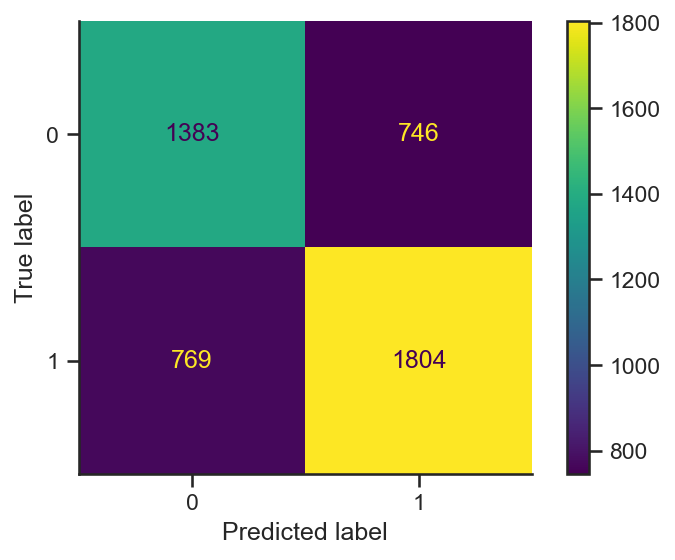

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=logit_tuned.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logit_tuned.classes_)
disp.plot()

#plt.title('LOGIT CONFUSION MATRIX', fontsize=10)
plt.savefig("conf_matrix_logit.png", bbox_inches="tight")
plt.show()

---

## SVM model with linear kernel

In [16]:
svc_linear = SVC(cache_size=6000, max_iter=5000, kernel='linear', class_weight='balanced')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_linear)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncode

In [17]:
# Training SVM Linear Kernel
%timeit svc_linear_fitted = pipeline.fit(X_train, y_train)

4.04 s ± 314 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.47      0.06      0.11      2129
     class 1       0.55      0.94      0.69      2573

    accuracy                           0.54      4702
   macro avg       0.51      0.50      0.40      4702
weighted avg       0.51      0.54      0.43      4702



* The precision will be "how many are correctly classified among that class"
    * Precision = TP / (TP + FP)
* The recall means "how many of this class we find over the whole number of element of this class"
    *  Recall = TP / (TP + FN)
* The f1-score is the harmonic mean between precision & recall
    * F1 Score = 2 * (Recall * Precision) / (Recall + Precision)
* The accuracy is the number of correctly predicted data points out of all the data points
    * Accuracy = (TP + TN) / (TP + TN + FP + FN)
* The support is the number of occurence of the given class in our dataset

Use weighted avg f1-score to compare models.

---

## SVM model with polynomial kernel (degree 2)

In [19]:
svc_poly_2 = SVC(cache_size=6000, max_iter=5000, kernel='poly', degree=2, class_weight='balanced')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_poly_2)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncode

In [20]:
# Training SVM Linear Kernel
%timeit svc_poly_2_fitted = pipeline.fit(X_train, y_train)

14.8 s ± 1.35 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.42      0.11      0.17      2129
     class 1       0.54      0.88      0.67      2573

    accuracy                           0.53      4702
   macro avg       0.48      0.49      0.42      4702
weighted avg       0.49      0.53      0.44      4702



---

## SVM model with polynomial kernel (degree 3)

In [22]:
svc_poly_3 = SVC(cache_size=6000, max_iter=5000, kernel='poly', degree=3, class_weight='balanced')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_poly_3)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncode

In [23]:
# Training SVM Linear Kernel
%timeit svc_poly_3_fitted = pipeline.fit(X_train, y_train)

13.6 s ± 401 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.44      0.06      0.11      2129
     class 1       0.55      0.94      0.69      2573

    accuracy                           0.54      4702
   macro avg       0.50      0.50      0.40      4702
weighted avg       0.50      0.54      0.43      4702



---

## SVM model with rbf kernel

In [25]:
svc_rbf = SVC(cache_size=6000, max_iter=5000, kernel='rbf', class_weight='balanced')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_rbf)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Receivables Turnover', 'Gross Profit Growth', 'EBIT Growth',
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
          

In [26]:
# Training SVM Linear Kernel
%timeit svc_rbf_fitted = pipeline.fit(X_train, y_train)

15.1 s ± 729 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))


              precision    recall  f1-score   support

     class 0       0.56      0.66      0.60      2129
     class 1       0.67      0.57      0.61      2573

    accuracy                           0.61      4702
   macro avg       0.61      0.61      0.61      4702
weighted avg       0.62      0.61      0.61      4702



---

## Hyperparameter tuning for final model

In [28]:
svc_rbf = SVC(cache_size=6000, max_iter=5000, kernel='rbf')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_rbf)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Receivables Turnover', 'Gross Profit Growth', 'EBIT Growth',
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
          

In [29]:
# Define Model Parameters for Grid Search
model_params = {
                'svc model__C':loguniform(1e0, 1e3),
                'svc model__gamma':loguniform(1e-4, 1e1)
                }

In [30]:
# Grid Search
prediction.find_best_parameters_for_model(pipeline,
                                          X_train,
                                          y_train,
                                          model_params,
                                          scoring='f1',
                                          n_iter=50,
                                          n_splits=5,
                                          n_repeats=2,
                                          verbose=10)

Running grid search for the model based on f1
Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 1/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.681 total time=  24.8s
[CV 2/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 2/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.685 total time=  27.3s
[CV 3/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 3/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.680 total time=  23.9s
[CV 4/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 4/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.674 total time=  24.4s
[CV 5/10; 1/50] START svc model__C=13.292918943

[CV 9/10; 4/50] END svc model__C=1.4936568554617629, svc model__gamma=2.142302175774106;, score=0.680 total time=  21.9s
[CV 10/10; 4/50] START svc model__C=1.4936568554617629, svc model__gamma=2.142302175774106
[CV 10/10; 4/50] END svc model__C=1.4936568554617629, svc model__gamma=2.142302175774106;, score=0.684 total time=  21.5s
[CV 1/10; 5/50] START svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412
[CV 1/10; 5/50] END svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412;, score=0.688 total time=  20.2s
[CV 2/10; 5/50] START svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412
[CV 2/10; 5/50] END svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412;, score=0.678 total time=  20.9s
[CV 3/10; 5/50] START svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412
[CV 3/10; 5/50] END svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412;, score=0.687 total time=  21.5s
[CV 4/10; 5/50] START svc model__C=63.5

[CV 8/10; 8/50] END svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602;, score=0.676 total time=  13.2s
[CV 9/10; 8/50] START svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602
[CV 9/10; 8/50] END svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602;, score=0.675 total time=  13.2s
[CV 10/10; 8/50] START svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602
[CV 10/10; 8/50] END svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602;, score=0.674 total time=  13.1s
[CV 1/10; 9/50] START svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869
[CV 1/10; 9/50] END svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869;, score=0.658 total time=  14.9s
[CV 2/10; 9/50] START svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869
[CV 2/10; 9/50] END svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869;, score=0.640 total time=  14.9s
[CV 3/10; 9/50] ST

[CV 6/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.676 total time=  14.3s
[CV 7/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 7/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.650 total time=  14.3s
[CV 8/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 8/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.658 total time=  14.4s
[CV 9/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 9/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.667 total time=  14.3s
[CV 10/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 10/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.657 total t

[CV 4/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.657 total time=  15.2s
[CV 5/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 5/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.677 total time=  14.9s
[CV 6/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 6/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.688 total time=  14.9s
[CV 7/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 7/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.650 total time=  14.8s
[CV 8/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 8/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.663 total time=  14.6s

[CV 3/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.563 total time=  11.9s
[CV 4/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 4/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.608 total time=  11.8s
[CV 5/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 5/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.605 total time=  12.1s
[CV 6/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 6/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.571 total time=  11.9s
[CV 7/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 7/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.564 total time=  11.7s
[CV 8/10

[CV 2/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.658 total time=  14.9s
[CV 3/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 3/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.653 total time=  14.9s
[CV 4/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 4/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.641 total time=  14.6s
[CV 5/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 5/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.641 total time=  14.7s
[CV 6/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 6/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.643 total time=  15.1s
[CV 7/10; 24/50] START svc

[CV 1/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.684 total time=  22.1s
[CV 2/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 2/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.682 total time=  23.1s
[CV 3/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 3/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.681 total time=  22.1s
[CV 4/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 4/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.674 total time=  22.0s
[CV 5/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 5/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.675 total time=  22.0s
[CV 6/10; 28/50] START svc model__C

[CV 9/10; 31/50] END svc model__C=14.656553886225332, svc model__gamma=0.002273762810253685;, score=0.642 total time=  14.4s
[CV 10/10; 31/50] START svc model__C=14.656553886225332, svc model__gamma=0.002273762810253685
[CV 10/10; 31/50] END svc model__C=14.656553886225332, svc model__gamma=0.002273762810253685;, score=0.656 total time=  14.7s
[CV 1/10; 32/50] START svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195
[CV 1/10; 32/50] END svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195;, score=0.563 total time=  12.0s
[CV 2/10; 32/50] START svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195
[CV 2/10; 32/50] END svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195;, score=0.616 total time=  12.6s
[CV 3/10; 32/50] START svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195
[CV 3/10; 32/50] END svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195;, score=0.557 total time=  11.9s
[CV 4/10;

[CV 8/10; 35/50] END svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274;, score=0.677 total time=  22.2s
[CV 9/10; 35/50] START svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274
[CV 9/10; 35/50] END svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274;, score=0.685 total time=  22.2s
[CV 10/10; 35/50] START svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274
[CV 10/10; 35/50] END svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274;, score=0.683 total time=  22.3s
[CV 1/10; 36/50] START svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555
[CV 1/10; 36/50] END svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555;, score=0.645 total time=  13.6s
[CV 2/10; 36/50] START svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555
[CV 2/10; 36/50] END svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555;, score=0.653 total time=  13.5s
[CV 3/10

[CV 6/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.659 total time=  14.8s
[CV 7/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 7/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.663 total time=  14.6s
[CV 8/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 8/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.676 total time=  14.8s
[CV 9/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 9/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.691 total time=  14.7s
[CV 10/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 10/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.67

[CV 4/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.643 total time=  14.5s
[CV 5/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 5/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.661 total time=  14.3s
[CV 6/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 6/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.632 total time=  14.8s
[CV 7/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 7/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.637 total time=  14.4s
[CV 8/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 8/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.639 total time=  14.5s
[CV 9/10; 43/50] 

[CV 2/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.620 total time=  13.0s
[CV 3/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 3/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.599 total time=  12.7s
[CV 4/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 4/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.603 total time=  13.0s
[CV 5/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 5/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.612 total time=  12.8s
[CV 6/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 6/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.591 total time=  13.0s
[CV 7/10

[CV 10/10; 50/50] END svc model__C=1.191948194791873, svc model__gamma=0.0003463037026119183;, score=0.702 total time=  13.4s
Best f1 Score was: 0.7010164907523324
The best hyper parameters for the model are:
{'svc model__C': 1.191948194791873, 'svc model__gamma': 0.0003463037026119183}


In [12]:
svc_tuned = SVC(cache_size=6000, max_iter=5000, kernel='rbf', gamma=0.0008399864445957498, C=43.66473592979633)

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncode

In [13]:
svc_tuned_fitted = pipeline.fit(X_train, y_train)

In [14]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.61      0.16      0.26      2129
     class 1       0.57      0.91      0.70      2573

    accuracy                           0.57      4702
   macro avg       0.59      0.54      0.48      4702
weighted avg       0.59      0.57      0.50      4702



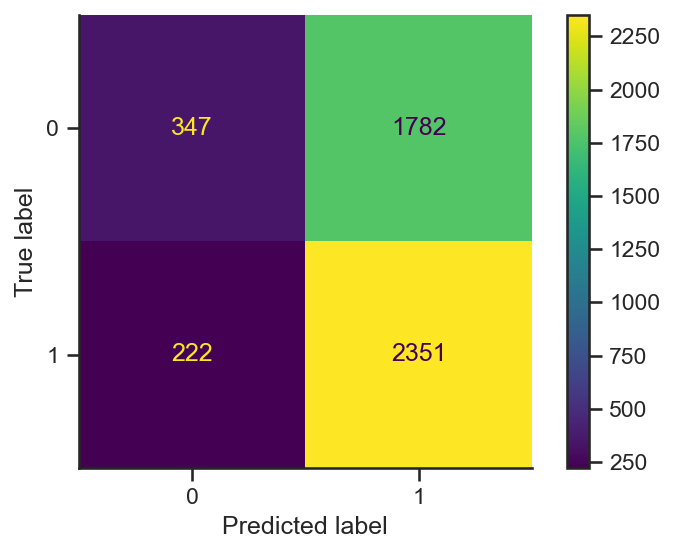

In [15]:
cm = confusion_matrix(y_test, y_pred, labels=svc_tuned.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc_tuned.classes_)
disp.plot()

#plt.title('SVM CONFUSION MATRIX', fontsize=10)
plt.savefig("conf_matrix_normal.png", bbox_inches="tight")
plt.show()

* Risikoavers nutzt Precision
* Risikoaffin nutzt Recall
* Risikoneutral nutzt F1

## Being risk averse

In [27]:
svc_rbf = SVC(cache_size=6000, max_iter=5000, kernel='rbf')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_rbf)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Receivables Turnover', 'Gross Profit Growth', 'EBIT Growth',
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
          

In [28]:
# Define Model Parameters for Grid Search
model_params = {
                'svc model__C':loguniform(1e0, 1e3),
                'svc model__gamma':loguniform(1e-4, 1e1)
                }

In [29]:
# Grid Search
prediction.find_best_parameters_for_model(pipeline,
                                          X_train,
                                          y_train,
                                          model_params,
                                          scoring='precision',
                                          n_iter=50,
                                          n_splits=5,
                                          n_repeats=2,
                                          verbose=10)

Running grid search for the model based on precision
Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 1/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.558 total time=  22.2s
[CV 2/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 2/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.558 total time=  22.2s
[CV 3/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 3/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.552 total time=  21.9s
[CV 4/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 4/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.550 total time=  22.0s
[CV 5/10; 1/50] START svc model__C=13.29

[CV 9/10; 4/50] END svc model__C=1.4936568554617629, svc model__gamma=2.142302175774106;, score=0.566 total time=  21.4s
[CV 10/10; 4/50] START svc model__C=1.4936568554617629, svc model__gamma=2.142302175774106
[CV 10/10; 4/50] END svc model__C=1.4936568554617629, svc model__gamma=2.142302175774106;, score=0.569 total time=  21.5s
[CV 1/10; 5/50] START svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412
[CV 1/10; 5/50] END svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412;, score=0.623 total time=  20.2s
[CV 2/10; 5/50] START svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412
[CV 2/10; 5/50] END svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412;, score=0.615 total time=  20.3s
[CV 3/10; 5/50] START svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412
[CV 3/10; 5/50] END svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412;, score=0.615 total time=  20.1s
[CV 4/10; 5/50] START svc model__C=63.5

[CV 8/10; 8/50] END svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602;, score=0.685 total time=  20.3s
[CV 9/10; 8/50] START svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602
[CV 9/10; 8/50] END svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602;, score=0.688 total time=  20.1s
[CV 10/10; 8/50] START svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602
[CV 10/10; 8/50] END svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602;, score=0.690 total time=  20.1s
[CV 1/10; 9/50] START svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869
[CV 1/10; 9/50] END svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869;, score=0.683 total time=  15.8s
[CV 2/10; 9/50] START svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869
[CV 2/10; 9/50] END svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869;, score=0.659 total time=  15.8s
[CV 3/10; 9/50] ST

[CV 6/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.682 total time=  19.7s
[CV 7/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 7/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.675 total time=  19.4s
[CV 8/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 8/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.683 total time=  19.6s
[CV 9/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 9/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.677 total time=  19.6s
[CV 10/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 10/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.684 total t

[CV 4/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.589 total time=  17.5s
[CV 5/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 5/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.633 total time=  18.2s
[CV 6/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 6/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.647 total time=  18.0s
[CV 7/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 7/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.577 total time=  17.8s
[CV 8/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 8/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.627 total time=  18.1s

[CV 3/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.628 total time=  12.4s
[CV 4/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 4/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.652 total time=  12.4s
[CV 5/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 5/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.642 total time=  12.4s
[CV 6/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 6/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.613 total time=  12.4s
[CV 7/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 7/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.614 total time=  12.4s
[CV 8/10

[CV 2/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.675 total time=  15.3s
[CV 3/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 3/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.685 total time=  15.3s
[CV 4/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 4/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.665 total time=  15.1s
[CV 5/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 5/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.691 total time=  15.1s
[CV 6/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 6/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.678 total time=  15.3s
[CV 7/10; 24/50] START svc

[CV 1/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.565 total time=  21.4s
[CV 2/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 2/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.559 total time=  21.3s
[CV 3/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 3/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.556 total time=  21.4s
[CV 4/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 4/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.554 total time=  21.5s
[CV 5/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 5/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.550 total time=  21.5s
[CV 6/10; 28/50] START svc model__C

[CV 9/10; 31/50] END svc model__C=14.656553886225332, svc model__gamma=0.002273762810253685;, score=0.687 total time=  17.2s
[CV 10/10; 31/50] START svc model__C=14.656553886225332, svc model__gamma=0.002273762810253685
[CV 10/10; 31/50] END svc model__C=14.656553886225332, svc model__gamma=0.002273762810253685;, score=0.683 total time=  17.5s
[CV 1/10; 32/50] START svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195
[CV 1/10; 32/50] END svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195;, score=0.563 total time=  11.8s
[CV 2/10; 32/50] START svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195
[CV 2/10; 32/50] END svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195;, score=0.580 total time=  11.7s
[CV 3/10; 32/50] START svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195
[CV 3/10; 32/50] END svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195;, score=0.589 total time=  11.9s
[CV 4/10;

[CV 8/10; 35/50] END svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274;, score=0.548 total time=  22.1s
[CV 9/10; 35/50] START svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274
[CV 9/10; 35/50] END svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274;, score=0.552 total time=  22.1s
[CV 10/10; 35/50] START svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274
[CV 10/10; 35/50] END svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274;, score=0.553 total time=  22.2s
[CV 1/10; 36/50] START svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555
[CV 1/10; 36/50] END svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555;, score=0.557 total time=  13.9s
[CV 2/10; 36/50] START svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555
[CV 2/10; 36/50] END svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555;, score=0.554 total time=  13.9s
[CV 3/10

[CV 6/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.591 total time=  16.3s
[CV 7/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 7/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.570 total time=  16.2s
[CV 8/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 8/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.567 total time=  16.2s
[CV 9/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 9/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.565 total time=  16.4s
[CV 10/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 10/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.58

[CV 4/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.662 total time=  17.6s
[CV 5/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 5/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.686 total time=  17.7s
[CV 6/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 6/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.687 total time=  17.7s
[CV 7/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 7/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.682 total time=  17.6s
[CV 8/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 8/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.685 total time=  17.8s
[CV 9/10; 43/50] 

[CV 2/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.660 total time=  13.0s
[CV 3/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 3/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.669 total time=  12.6s
[CV 4/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 4/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.660 total time=  12.9s
[CV 5/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 5/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.678 total time=  12.6s
[CV 6/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 6/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.683 total time=  12.9s
[CV 7/10

[CV 10/10; 50/50] END svc model__C=1.191948194791873, svc model__gamma=0.0003463037026119183;, score=0.571 total time=  24.2s
Best precision Score was: 0.6881578154680987
The best hyper parameters for the model are:
{'svc model__C': 8.200518402245828, 'svc model__gamma': 0.0003078651783619618}


In [16]:
svc_tuned = SVC(cache_size=6000, max_iter=5000, kernel='rbf', gamma=0.0003078651783619618, C=8.200518402245828)

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncode

In [17]:
svc_tuned_fitted = pipeline.fit(X_train, y_train)

In [18]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.69      0.39      0.49      2129
     class 1       0.63      0.86      0.72      2573

    accuracy                           0.64      4702
   macro avg       0.66      0.62      0.61      4702
weighted avg       0.66      0.64      0.62      4702



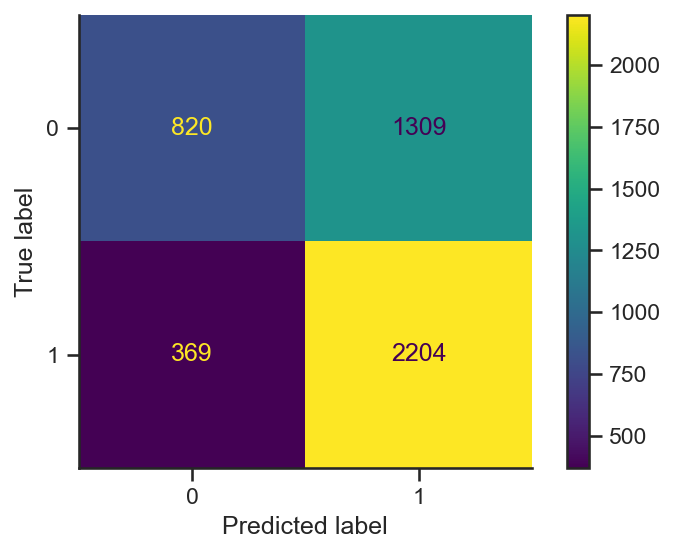

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=svc_tuned.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc_tuned.classes_)
disp.plot()

#plt.title('AVERSE CONFUSION MATRIX', fontsize=10)
plt.savefig("conf_matrix_averse.png", bbox_inches="tight")
plt.show()

## Being risk affine

In [34]:
svc_rbf = SVC(cache_size=6000, max_iter=5000, kernel='rbf')

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_rbf)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Receivables Turnover', 'Gross Profit Growth', 'EBIT Growth',
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
          

In [35]:
# Define Model Parameters for Grid Search
model_params = {
                'svc model__C':loguniform(1e0, 1e3),
                'svc model__gamma':loguniform(1e-4, 1e1)
                }

In [36]:
# Grid Search
prediction.find_best_parameters_for_model(pipeline,
                                          X_train,
                                          y_train,
                                          model_params,
                                          scoring='recall',
                                          n_iter=50,
                                          n_splits=5,
                                          n_repeats=2,
                                          verbose=10)

Running grid search for the model based on recall
Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 1/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.872 total time=  22.0s
[CV 2/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 2/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.886 total time=  22.0s
[CV 3/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 3/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.887 total time=  22.0s
[CV 4/10; 1/50] START svc model__C=13.292918943162162, svc model__gamma=5.669849511478852
[CV 4/10; 1/50] END svc model__C=13.292918943162162, svc model__gamma=5.669849511478852;, score=0.868 total time=  22.0s
[CV 5/10; 1/50] START svc model__C=13.29291

[CV 9/10; 4/50] END svc model__C=1.4936568554617629, svc model__gamma=2.142302175774106;, score=0.852 total time=  22.0s
[CV 10/10; 4/50] START svc model__C=1.4936568554617629, svc model__gamma=2.142302175774106
[CV 10/10; 4/50] END svc model__C=1.4936568554617629, svc model__gamma=2.142302175774106;, score=0.857 total time=  21.9s
[CV 1/10; 5/50] START svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412
[CV 1/10; 5/50] END svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412;, score=0.768 total time=  20.6s
[CV 2/10; 5/50] START svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412
[CV 2/10; 5/50] END svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412;, score=0.756 total time=  20.6s
[CV 3/10; 5/50] START svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412
[CV 3/10; 5/50] END svc model__C=63.5835885667625, svc model__gamma=0.3470266988650412;, score=0.779 total time=  20.4s
[CV 4/10; 5/50] START svc model__C=63.5

[CV 8/10; 8/50] END svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602;, score=0.749 total time=  20.4s
[CV 9/10; 8/50] START svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602
[CV 9/10; 8/50] END svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602;, score=0.758 total time=  20.3s
[CV 10/10; 8/50] START svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602
[CV 10/10; 8/50] END svc model__C=3.511356313970406, svc model__gamma=0.0008260808399079602;, score=0.758 total time=  20.3s
[CV 1/10; 9/50] START svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869
[CV 1/10; 9/50] END svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869;, score=0.664 total time=  15.8s
[CV 2/10; 9/50] START svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869
[CV 2/10; 9/50] END svc model__C=8.17949947521167, svc model__gamma=0.04205156450913869;, score=0.638 total time=  15.8s
[CV 3/10; 9/50] ST

[CV 6/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.774 total time=  17.2s
[CV 7/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 7/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.757 total time=  16.9s
[CV 8/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 8/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.752 total time=  17.3s
[CV 9/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 9/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.774 total time=  17.1s
[CV 10/10; 12/50] START svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855
[CV 10/10; 12/50] END svc model__C=7.5237428845348555, svc model__gamma=0.0067890532716984855;, score=0.759 total t

[CV 4/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.890 total time=  16.0s
[CV 5/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 5/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.868 total time=  16.6s
[CV 6/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 6/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.823 total time=  16.6s
[CV 7/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 7/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.906 total time=  16.2s
[CV 8/10; 16/50] START svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867
[CV 8/10; 16/50] END svc model__C=66.47135865318025, svc model__gamma=0.0007122305833333867;, score=0.843 total time=  16.6s

[CV 3/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.549 total time=  11.8s
[CV 4/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 4/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.564 total time=  11.7s
[CV 5/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 5/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.576 total time=  11.7s
[CV 6/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 6/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.491 total time=  11.7s
[CV 7/10; 20/50] START svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399
[CV 7/10; 20/50] END svc model__C=112.90133559092668, svc model__gamma=0.01587678152692399;, score=0.509 total time=  11.7s
[CV 8/10

[CV 2/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.689 total time=  15.5s
[CV 3/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 3/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.666 total time=  15.7s
[CV 4/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 4/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.649 total time=  15.5s
[CV 5/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 5/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.640 total time=  15.6s
[CV 6/10; 24/50] START svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687
[CV 6/10; 24/50] END svc model__C=8.61257919259488, svc model__gamma=0.03984190594434687;, score=0.665 total time=  15.8s
[CV 7/10; 24/50] START svc

[CV 1/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.867 total time=  22.0s
[CV 2/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 2/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.872 total time=  22.1s
[CV 3/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 3/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.879 total time=  22.0s
[CV 4/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 4/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.860 total time=  22.0s
[CV 5/10; 28/50] START svc model__C=62.18704727769077, svc model__gamma=4.067908494359545
[CV 5/10; 28/50] END svc model__C=62.18704727769077, svc model__gamma=4.067908494359545;, score=0.872 total time=  22.0s
[CV 6/10; 28/50] START svc model__C

[CV 9/10; 31/50] END svc model__C=14.656553886225332, svc model__gamma=0.002273762810253685;, score=0.769 total time=  16.8s
[CV 10/10; 31/50] START svc model__C=14.656553886225332, svc model__gamma=0.002273762810253685
[CV 10/10; 31/50] END svc model__C=14.656553886225332, svc model__gamma=0.002273762810253685;, score=0.784 total time=  17.1s
[CV 1/10; 32/50] START svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195
[CV 1/10; 32/50] END svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195;, score=0.578 total time=  11.5s
[CV 2/10; 32/50] START svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195
[CV 2/10; 32/50] END svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195;, score=0.617 total time=  11.5s
[CV 3/10; 32/50] START svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195
[CV 3/10; 32/50] END svc model__C=306.3462210622081, svc model__gamma=0.00607808309968195;, score=0.619 total time=  11.5s
[CV 4/10;

[CV 8/10; 35/50] END svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274;, score=0.885 total time=  21.5s
[CV 9/10; 35/50] START svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274
[CV 9/10; 35/50] END svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274;, score=0.901 total time=  21.4s
[CV 10/10; 35/50] START svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274
[CV 10/10; 35/50] END svc model__C=1.6736010167825774, svc model__gamma=8.598737339212274;, score=0.893 total time=  21.4s
[CV 1/10; 36/50] START svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555
[CV 1/10; 36/50] END svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555;, score=0.800 total time=  13.5s
[CV 2/10; 36/50] START svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555
[CV 2/10; 36/50] END svc model__C=207.36445177905023, svc model__gamma=0.0009853225172032555;, score=0.829 total time=  13.5s
[CV 3/10

[CV 6/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.908 total time=  15.8s
[CV 7/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 7/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.917 total time=  15.8s
[CV 8/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 8/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.935 total time=  16.0s
[CV 9/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 9/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.939 total time=  16.0s
[CV 10/10; 39/50] START svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518
[CV 10/10; 39/50] END svc model__C=205.97335357437186, svc model__gamma=0.00023454342277260518;, score=0.91

[CV 4/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.758 total time=  17.6s
[CV 5/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 5/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.759 total time=  17.7s
[CV 6/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 6/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.786 total time=  17.8s
[CV 7/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 7/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.739 total time=  17.6s
[CV 8/10; 43/50] START svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167
[CV 8/10; 43/50] END svc model__C=8.56933192505398, svc model__gamma=0.004225874644996167;, score=0.758 total time=  17.9s
[CV 9/10; 43/50] 

[CV 2/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.585 total time=  12.9s
[CV 3/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 3/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.543 total time=  12.7s
[CV 4/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 4/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.555 total time=  12.9s
[CV 5/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 5/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.557 total time=  12.7s
[CV 6/10; 47/50] START svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171
[CV 6/10; 47/50] END svc model__C=191.58219548093157, svc model__gamma=0.06403036652671171;, score=0.521 total time=  12.9s
[CV 7/10

[CV 10/10; 50/50] END svc model__C=1.191948194791873, svc model__gamma=0.0003463037026119183;, score=0.968 total time=  24.1s
Best recall Score was: 0.9663146954825234
The best hyper parameters for the model are:
{'svc model__C': 1.191948194791873, 'svc model__gamma': 0.0003463037026119183}


In [20]:
svc_tuned = SVC(cache_size=6000, max_iter=5000, kernel='rbf', gamma=0.0003463037026119183, C=1.191948194791873)

pipeline = prediction.make_pipeline_for_svm(cat_vars, cont_vars, svc_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  array(['Revenue', 'Revenue Growth', 'Gross Profit', 'R&D Expenses',
       'SG&A Expense', 'Operating Expenses', 'Operating Income',
       'Interest Expense', 'Earnings before Tax', 'Income Tax Expense',
       'Net Income - Non-Controlling int',
       'Net Income -...
       'Operating Income Growth', 'Net Income Growth', 'EPS Growth',
       'Operating Cash Flow growth', 'Receivables growth', 'Asset Growth'],
      dtype=object)),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncode

In [21]:
svc_tuned_fitted = pipeline.fit(X_train, y_train)

In [22]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.57      0.00      0.01      2129
     class 1       0.55      1.00      0.71      2573

    accuracy                           0.55      4702
   macro avg       0.56      0.50      0.36      4702
weighted avg       0.56      0.55      0.39      4702



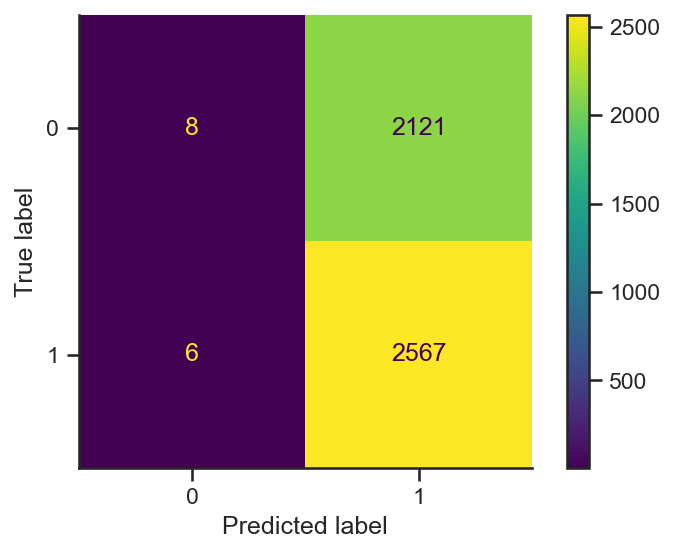

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=svc_tuned.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc_tuned.classes_)
disp.plot()

#plt.title('AFFINE CONFUSION MATRIX', fontsize=10)
plt.savefig("conf_matrix_affine.png", bbox_inches="tight")
plt.show()